В этой тетрадке напишем градиентный спуск своими ручками для линейной регрессии. Поэкспериментируем с различными функциями потерь и поиграемся с гиперпараметрами

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск

Для начала вспомним как выглядит MSE

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [ ]:
import abc


class BaseLoss(abc.ABC):

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Реализуем класс `MSELoss`


In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        l = X.shape[0]
        loss = np.sum((X @ w - y) ** 2) / l
        return loss

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        l = X.shape[0]
        grad = 2 * X.T @ (X @ w - y) / l
        return grad

Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

Реализуем функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать
траекторию спуска (список из новых значений весов на каждом шаге)

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # -- YOUR CODE HERE --

    VVS = [w_init]
    for i in range(n_iterations):
        res = lr * loss.calc_grad(X, y, VVS[i])
        w = VVS[i] - res
        VVS.append(w)
    return VVS

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [ ]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])


    plt.show()

Отрисуем графики с различным learning rate и сделаем вывод, как он влияет на поведение спуска

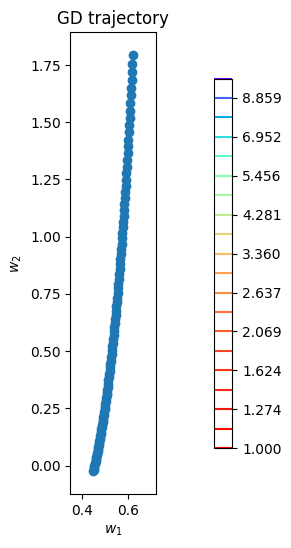

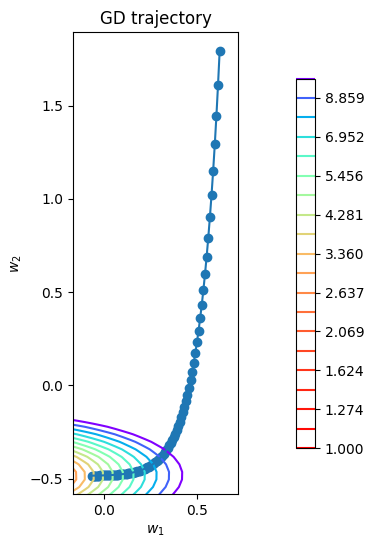

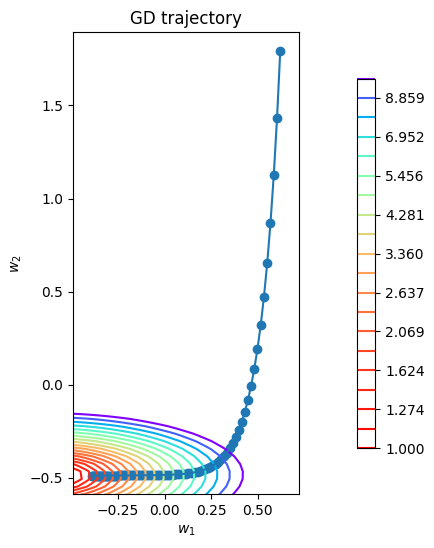

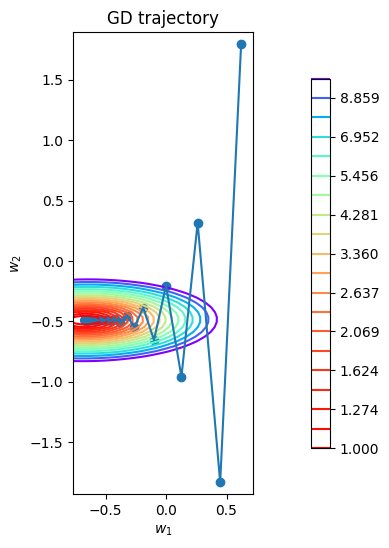

In [ ]:
# -- YOUR CODE HERE --
loss = MSELoss()
for i in [0.0001, 0.0005, 0.001, 0.01]:
  VVS = gradient_descent(w_init, X, y, loss, i, 100)
  plot_gd(VVS, X, y, loss)

Если lr слишком маленький, градиентный спуск будет двигаться очень медленно к оптимальной точке. Это может привести к долгому времени обучения и неэффективности алгоритма.
Если lr слишком большой, градиентный спуск может "перепрыгивать" через оптимальную точку или даже расходиться, что приведет к неправильным результатам.

Из наших графиков все графики можно назвать хорошими, кроме последнего - там веса скачут вверх вниз, довольно быстро, но так можно и перепрыгнуть нужное значение, и возможно, первого - очень долго сходится


Теперь реализуем стохастический градиентный спуск

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.


In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    VVS = [w_init]
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w = VVS[i] - lr * loss.calc_grad(X_batch, y_batch, VVS[i])
        VVS.append(w)

    return VVS


Аналогично отрисуем траектории, только сейчас добавляется еще параметр batch_size

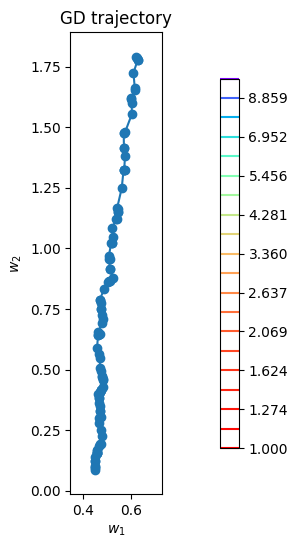

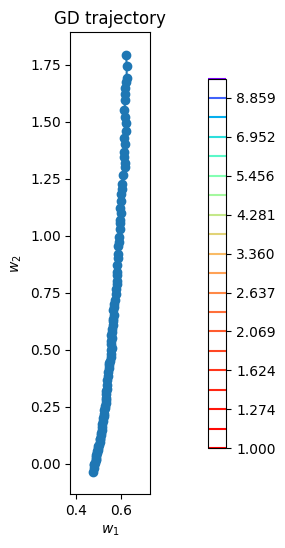

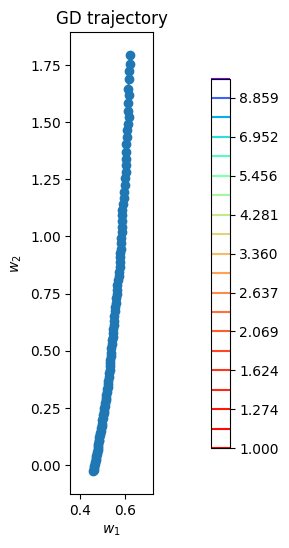

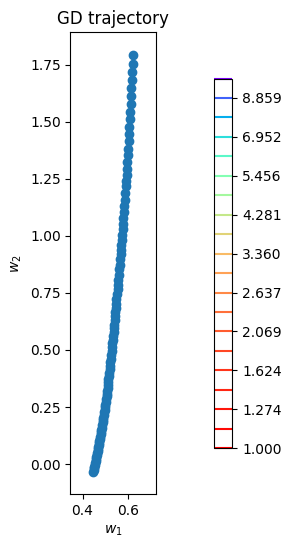

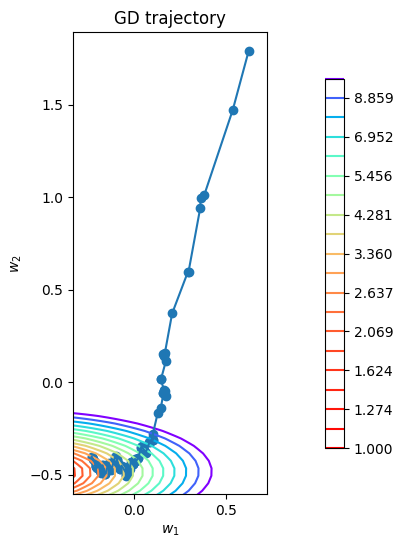

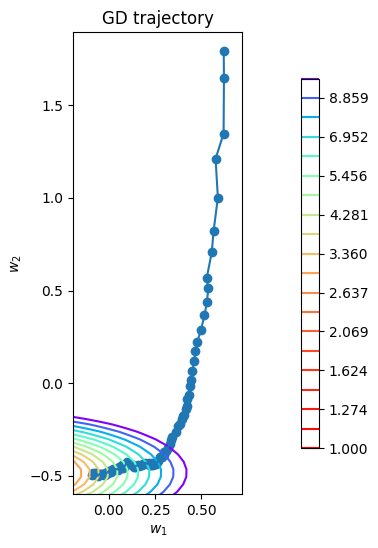

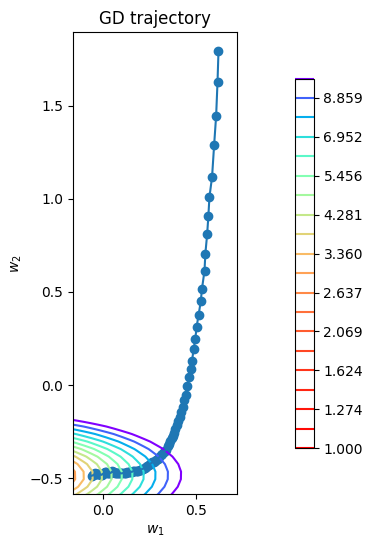

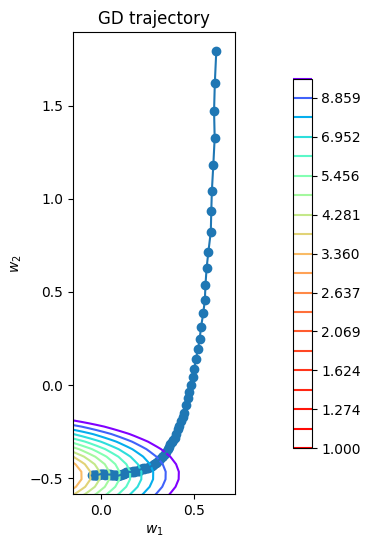

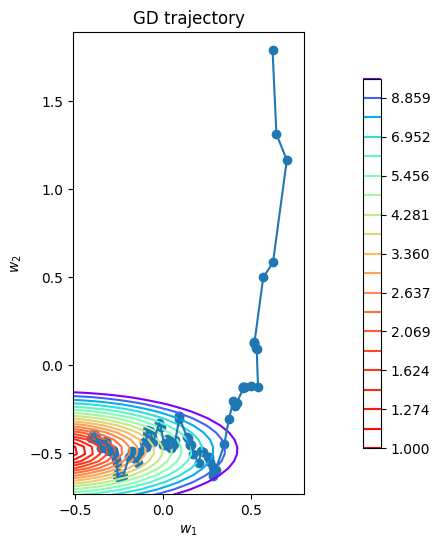

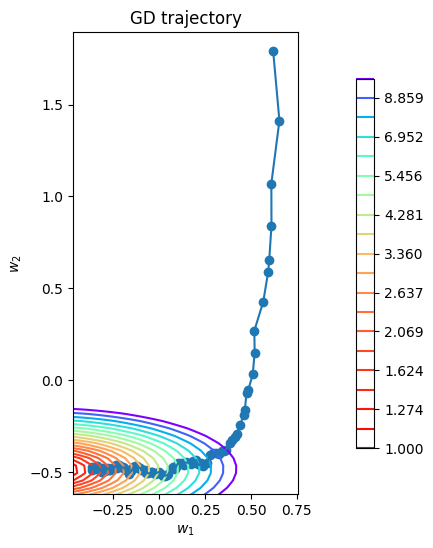

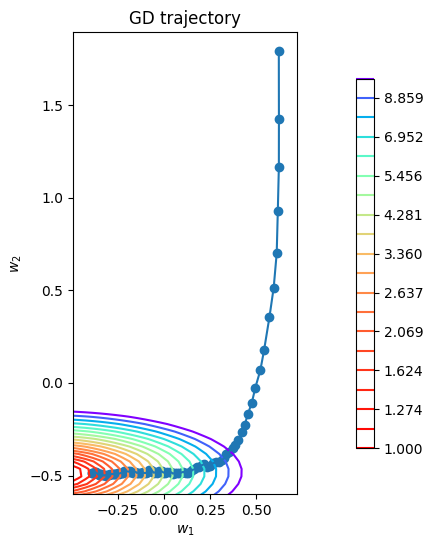

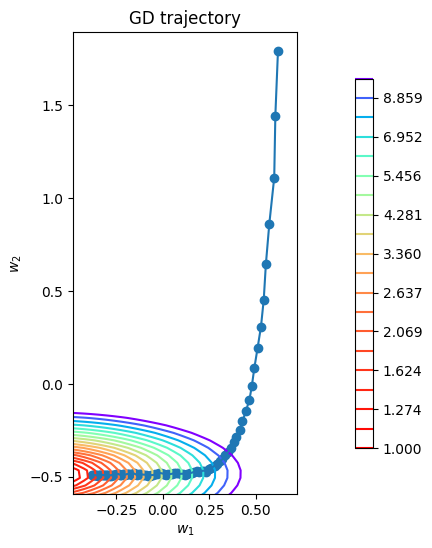

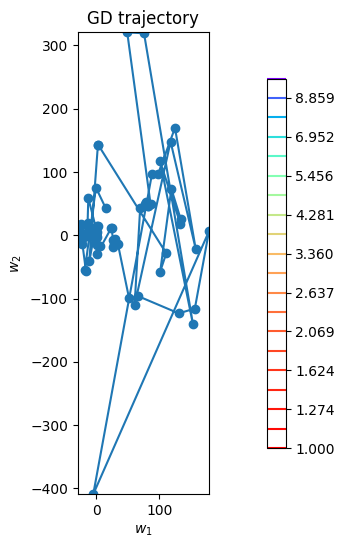

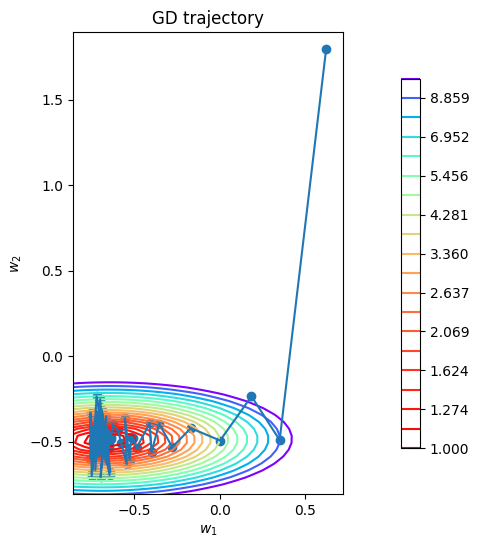

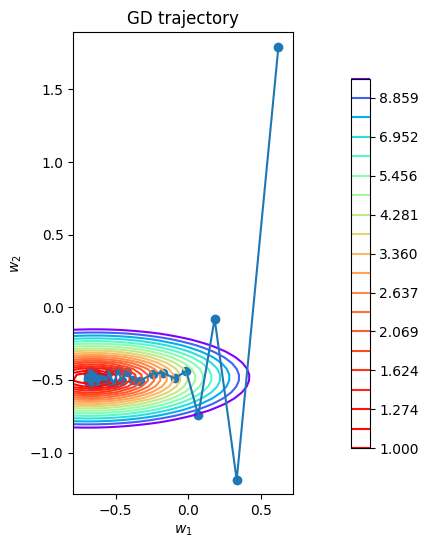

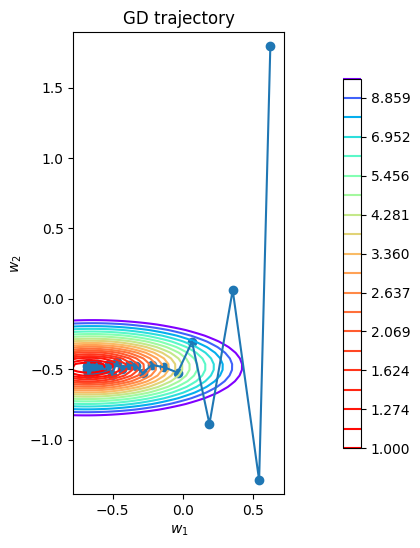

In [ ]:
loss = MSELoss()
for lr in [0.0001, 0.0005, 0.001, 0.01]:
  for batch_size in [1, 10, 50, 100]:
    VVS = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, 100)
    plot_gd(VVS, X, y, loss)

Параметр lr влияет так же, как на обычный градиентный спуск.

При увеличении размера подвыборки batch_size, траектория стохастического градиентного спуска становится более гладкой, и его поведение становится более похожим на обычный градиентный спуск.

При малом размере подвыборки batch_size, например 1, стохастический градиентный спуск может демонстрировать очень случайное поведение(при lr = 0.01 там вообще кошмар) и долго сходиться, особенно при высоких значениях lr.

Можно заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуем

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 10000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """

    VVS = [w_init]
    for i in range(1, n_iterations + 1):  # начинаем с t = 1
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        eta_t = lr * ((1 / (1 + i)) ** p)
        w = VVS[i - 1] - eta_t * loss.calc_grad(X_batch, y_batch, VVS[i - 1])
        VVS.append(w)

    return VVS

Аналогично поиграемся с гиперпараметрами

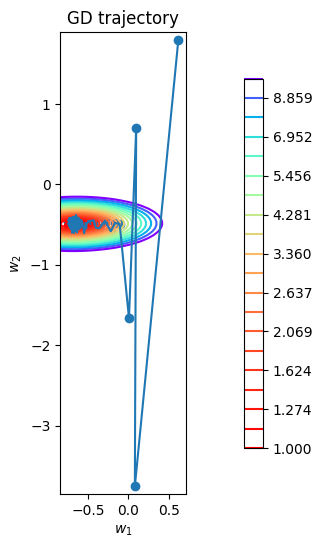

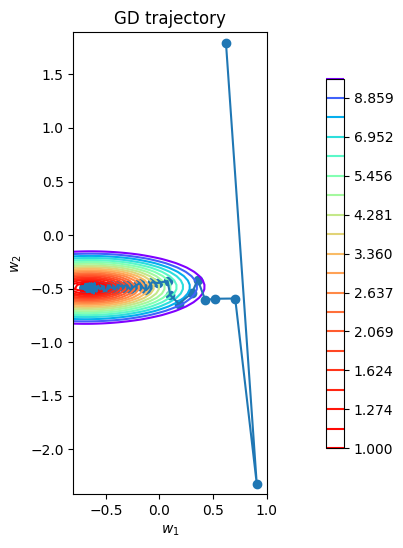

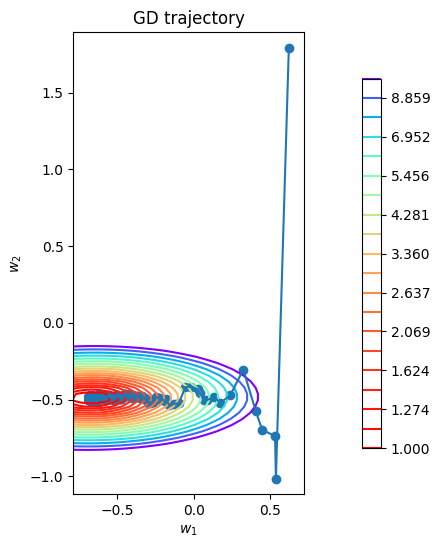

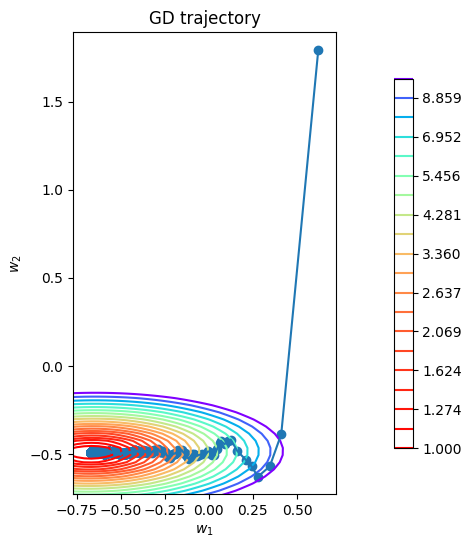

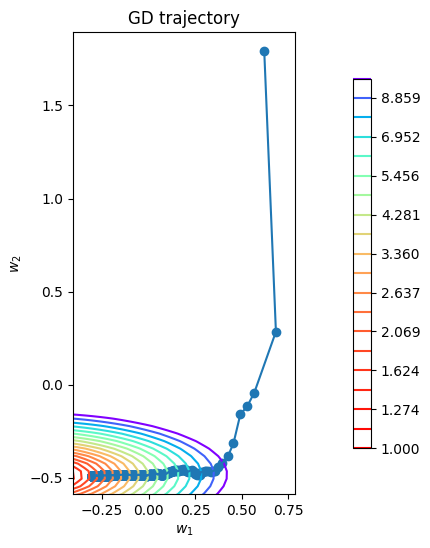

In [ ]:
# -- YOUR CODE HERE --
for p in [0.1, 0.3, 0.5, 0.7, 1]:
    w_history = stochastic_gradient_descent(w_init, X, y, MSELoss(), 0.01, 10, p)
    plot_gd(w_history, X, y, MSELoss())

Чем больше p, тем быстрее уменьшается шаг, поэтому, уменьшается вероятность перепрыгивания минимума, но увеличивается вероятность ненахождения минимума.

при маленьком p очень много итераций в самом начале "топчатся", при увеличении p все больше напоминает обычный стохастический град спуск

Сравним сходимость обычного градиентного спуска и стохастичекой версии

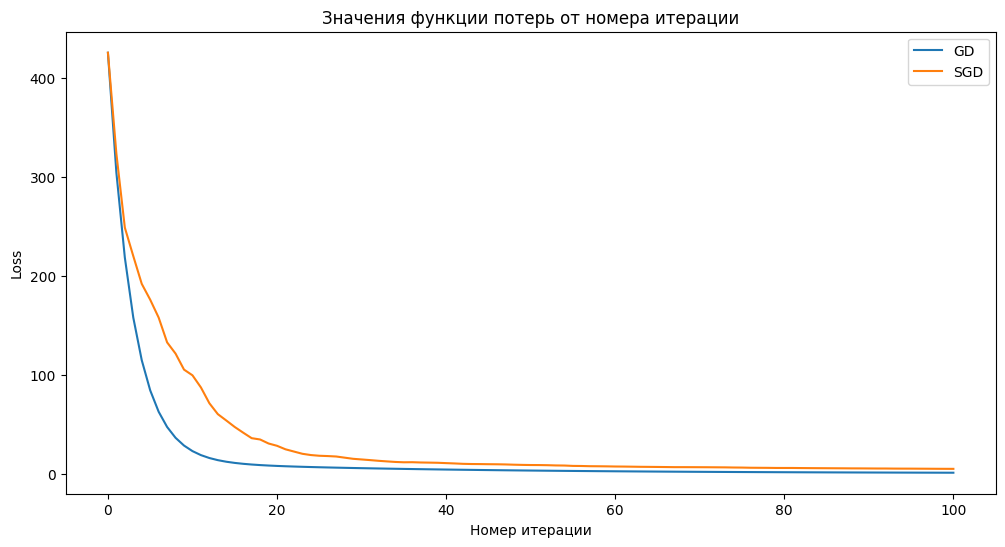

In [ ]:
VVS = gradient_descent(w_init, X, y, loss, 0.001, 100)
VVS_sgd = stochastic_gradient_descent(w_init, X, y, loss, 0.001, 10, 0.3, 100)

loss_gd = [loss.calc_loss(X, y, w) for w in VVS]
loss_sgd = [loss.calc_loss(X, y, w) for w in VVS_sgd]

plt.figure(figsize=(12, 6))
plt.plot(loss_gd, label='GD')
plt.plot(loss_sgd, label='SGD')
plt.xlabel('Номер итерации')
plt.ylabel('Loss')
plt.title('Значения функции потерь от номера итерации')
plt.legend()
plt.show()

SGD имеет не очень стабильную структуру из-за случайного выбора подвыборки на каждой итерации, что можно увидеть на графике в виде характерной ?кривизны?
При большом количестве итерации они показывают почти одинаковые результаты, однако SGD работает намного быстрее и использует меньше ресурсов, что и показывает его преимущество

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету,

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        # Инициализация весов w случайными значениями
        w_init = np.random.rand(X.shape[1])

        # Применение градиентного спуска и сохранение последней w из траектории
        w_list = gradient_descent(w_init, X, y, self.loss, self.lr)
        self.w = w_list[-1]
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        y_pred = X @ self.w
        return y_pred


Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)
X_raw = X_raw.drop('index', axis=1)

Обработаем датасет след образом:

* Разделим датасет на обучающую и тестовую выборку
* Заполним пропуски
* Нормализуем числовые признаки
* Закодируем категориальные переменные

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
np.random.seed(230)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state = 21)

In [ ]:
X_raw.isna().any()

0     False
1      True
2     False
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18     True
19     True
20    False
21     True
22     True
23    False
24    False
dtype: bool

Видим довольно много столбцов с пропусками

In [ ]:
X_raw.dtypes

0       int64
1     float64
2      object
3      object
4      object
5      object
6      object
7      object
8      object
9     float64
10    float64
11    float64
12    float64
13      int64
14     object
15     object
16      int64
17     object
18    float64
19    float64
20    float64
21    float64
22    float64
23      int64
24      int64
dtype: object

In [ ]:
X_raw.columns = X_raw.columns.astype(str)
X_train.columns = X_train.columns.astype(str)  # питон ругался
X_test.columns = X_test.columns.astype(str)

num_imputer = SimpleImputer(strategy="mean")
cat_features_mask = (X_raw.dtypes == "object")  # маска категориальных и вещественных данных
num_features_mask = (X_raw.dtypes != "object")

cat_features = X_raw.columns[cat_features_mask].tolist()  # преобразование в список с названиями
num_features = X_raw.columns[num_features_mask].tolist()  # столбцов кат/нум данных

X_train_num = num_imputer.fit_transform(X_train[num_features])  # на выходе не датафрейм
X_test_num = num_imputer.transform(X_test[num_features])

X_train_cat = X_train[cat_features].fillna("")  # а тут датафрейм
X_test_cat = X_test[cat_features].fillna("")

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
normalizer = StandardScaler()

X_train_num_scaled = normalizer.fit_transform(X_train_num)  # Нормализация числовых признаков

X_test_num_scaled = normalizer.fit_transform(X_test_num)

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')  # если делать через dummies при объединении получается мильон нанов

X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

In [ ]:
cat_features_dum_tr = encoder.get_feature_names_out(input_features=X_train_cat.columns).tolist()
cat_features_dum_t = encoder.get_feature_names_out(input_features=X_test_cat.columns).tolist()  # списки с названиями столбцов

X_train_processed = np.hstack([X_train_num_scaled, X_train_cat_encoded.toarray()])
X_test_processed = np.hstack([X_test_num_scaled, X_test_cat_encoded.toarray()])  # объединяем два массива
X_train_processed_df = pd.DataFrame(X_train_processed, columns=num_features + cat_features_dum_tr)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=num_features + cat_features_dum_t)  # преобразуем в дф

Обучим модельку

In [ ]:
# -- YOUR CODE HERE --
np.random.seed(230)
reg = linear_regression.fit(X_train_processed_df, y_train)

Посчитаем лосс

In [ ]:
from sklearn.metrics import mean_squared_error

# -- YOUR CODE HERE --
print(f"MSE for train: {mean_squared_error(y_train, reg.predict(X_train_processed_df))}")
print(f"MSE for test: {mean_squared_error(y_test, reg.predict(X_test_processed_df))}")

MSE for train: 2002671.5434217062
MSE for test: 7711425.756426945


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Реализуем класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        loss = np.sum((X @ w - y) ** 2)/X.shape[0] + self.coef * np.sum(w[:-1] ** 2)
        return loss

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        l = X.shape[0]
        grad = 2 * X.T @ (X @ w - y) / l + 2 * self.coef * w
        grad[-1] = 0  # исключаем влияние bias на регуляризацию
        return grad

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSEL2Loss(0.005))

Обучим и посмотрим на лосс

In [ ]:
# -- YOUR CODE HERE --
np.random.seed(230)
linear_regression.fit(X_train_processed_df, y_train)
print(f"L2 Train loss: {mean_squared_error(y_train, linear_regression.predict(X_train_processed_df))}")
print(f"L2 Test loss: {mean_squared_error(y_test, linear_regression.predict(X_test_processed_df))}")

L2 Train loss: 2572490.7577801105
L2 Test loss: 4121677.0577018866


MSE на тестовой выборке довольно сильно уменьшилось, однако на тренировочной стало чуть больше

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

Реализуем класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычисления значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значение функции потерь
        """
        l = X.shape[0]
        z = X @ w - y
        loss = np.sum(np.where(np.abs(z) < self.eps, 0.5 * z**2, self.eps * (np.abs(z) - 0.5 * self.eps)))
        return loss / l

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычисления градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        l = X.shape[0]
        z = X @ w - y
        grad = X.T.dot(np.where(np.abs(z) < self.eps, z, self.eps * np.sign(z)))
        return grad / l


Обучим и посмотрим лосс

In [ ]:
# -- YOUR CODE HERE --
huber_reg = LinearRegression(HuberLoss(eps = 1))
huber_reg.fit(X_train_processed_df, y_train)

train_mse_huber = mean_squared_error(y_train, huber_reg.predict(X_train_processed_df))
test_mse_huber = mean_squared_error(y_test, huber_reg.predict(X_test_processed_df))

print(f"Huber Loss train loss: {train_mse_huber}")
print(f"Huber Loss test loss: {test_mse_huber}")

Huber Loss train loss: 14174625.839327376
Huber Loss test loss: 23684598.225011326


если брать eps огромным то модель будет просто повторять mseloss модель

если брать адекватные значения, то качество намного хуже выходит

это связано с тем, что хубер лос это MAE+MSE(грубо говоря), и на наших данных MAE плохо работает, поэтому такие лоссы большие(либо я накосячил где-то но я понятия не имею где((((((((((((((((()

### Имитация отжига

Попробуем написать алгоритм имитации отжига для оптимизации MSE линейной регрессии.

Сравним результат с градиентным спуском по "траектории" и по финальному лоссу.

In [ ]:
import warnings

warnings.filterwarnings('ignore')

T > 0 — убывающей к нулю положительной последовательности, которая задаёт аналог понижающейся температуры в кристалле. Скорость остывания (закон убывания) также может задаваться (и варьироваться) произвольно, что придаёт алгоритму значительной гибкости.

пусть будет последовательность, которая с каждой итерацией уменьшается на 1/n * deltaT градусов

In [ ]:
def simulated_annealing(X, y, n_iterations, start_temperature, final_temperature):
    l = X.shape[1]
    w = np.zeros(l)
    best_w = w
    best_loss = mean_squared_error(y, X @ w)

    current_temperature = start_temperature
    w_list = [w]
    for i in range(n_iterations):
        # Генерируем новые веса
        new_w = w + np.random.standard_t(3, size=w.shape)

        # Рассчитываем MSE для новой точки
        new_loss = mean_squared_error(y, X @ new_w)

        # Если новая точка улучшает MSE, переходим в нее
        if new_loss < best_loss:
            w = new_w
            best_loss = new_loss
        else:
            # Если нет, то принимаем новую точку с определенной вероятностью
            p = np.exp(-(new_loss - best_loss) / current_temperature)  # из википедии
            if np.random.rand() < p:  # если вероятность больше числа из норм расп(0,1) то переходим в эту точку
                w = new_w

        w_list.append(w)

        # Уменьшаем температуру
        current_temperature = final_temperature + (start_temperature - final_temperature) * (1 - i / n_iterations)

    return best_loss, w_list


In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


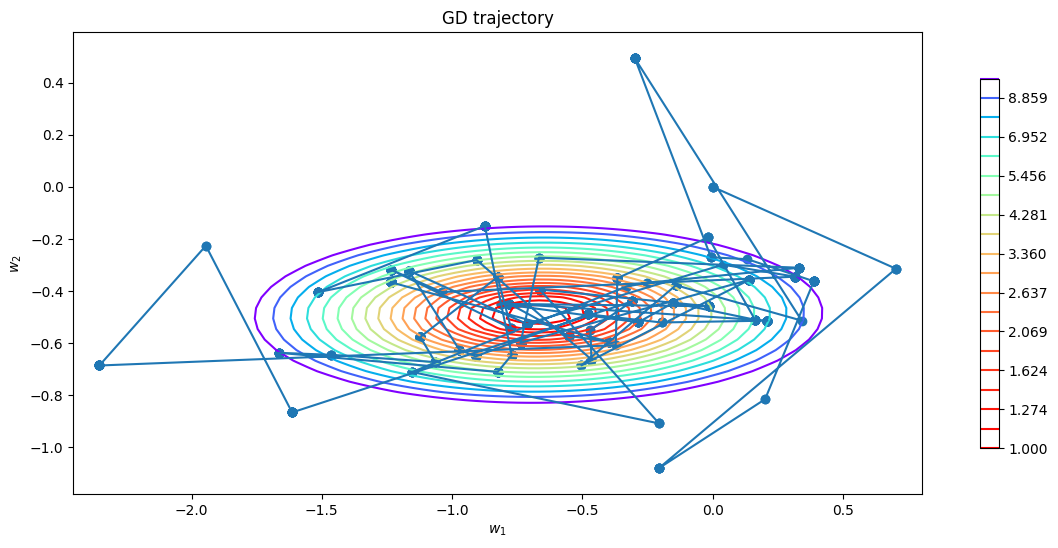

In [ ]:
np.random.seed(1)
n_iterations = 1000
start_temperature = 10
final_temperature = 0.0001
loss = MSELoss()
best_loss, w_list = simulated_annealing(X, y, n_iterations, start_temperature, final_temperature)

plot_gd(w_list, X, y, loss)


$masterpiece...$

In [ ]:
w_gd = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_gd[0]))
print(loss.calc_loss(X, y, w_gd[-1]))

w_sa = w_list
print(loss.calc_loss(X, y, w_sa[0]))
print(loss.calc_loss(X, y, w_sa[-1]))
print(best_loss)

425.58917680450253
0.8670644395649493
23.061500548443885
4.639977728239509
0.9828669318026628


прикольно получилось. Траектория максимально хаотичная, в отличие от градиентного спуска, но так и должно быть, в этом и прикол имитации отжига, идея заключается в том, чтобы исследовать пространство решений, а не застревать в локальных минимумах. Для этого алгоритм может временно принимать худшие решения с определенной вероятностью. Это позволяет алгоритму "перепрыгнуть" через локальные минимумы и продолжить поиск глобального минимума.

что касается лоссов, начальный лосс намного меньше(но это не особо важно), однако финальный лосс у градиентного спуска по-меньше будет
